In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta, time, datetime
from tqdm import tqdm
import math
# pandas max row 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [2]:
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100

In [3]:
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
%matplotlib inline
import statsmodels.api as sm

In [6]:
tot_data = pd.read_csv('/content/drive/MyDrive/KDT/tota_df.csv')
tot_data = tot_data[9:27025] #drop unknwon period(~2017060108, 2020070100~ )
tot_data = tot_data.reset_index(drop = True)
tot_data = tot_data.drop(['Unnamed: 0', 'date'],1)
tot_data.columns = ['datetime','solar_result', 'temp', 'rain_r', 'hum', 'wind', 'wins','sky','azimuth','altitude']
tot_data['datetime'] = pd.to_datetime(tot_data['datetime'], format = '%Y%m%d%H')
tot_data.head()

,datetime,solar_result,temp,rain_r,hum,wind,wins,sky,azimuth,altitude
0,2017-06-01 09:00:00,33.12,21.000000,0.0,65.000000,2.400000,2.400000,1.0,92.42,44.23
1,2017-06-01 10:00:00,50.16,21.333333,0.0,65.000000,2.333333,2.333333,1.0,NaN,NaN
2,2017-06-01 11:00:00,96.72,21.666667,0.0,65.000000,2.266667,2.266667,1.0,NaN,NaN
3,2017-06-01 12:00:00,120.96,22.000000,0.0,65.000000,2.200000,2.200000,1.0,158.50,76.04
4,2017-06-01 13:00:00,118.80,21.333333,0.0,63.333333,2.433333,2.433333,1.0,NaN,NaN


#01. 학습 데이터 전처리

In [7]:
dataset = tot_data.loc[:,'solar_result' :].astype('float')
dataset.index = tot_data['datetime']
dataset.isnull().sum()

solar_result        0
temp                0
rain_r              0
hum                 0
wind                0
wins                0
sky                 0
azimuth         23638
altitude        22512
dtype: int64

In [8]:
#시계열 속성 attribute로 추가
dataset['hour'] = tot_data['datetime'].apply(lambda x : x.hour).to_list()
dataset['year'] = tot_data['datetime'].apply(lambda x : x.year).to_list()
dataset['month'] = tot_data['datetime'].apply(lambda x : x.month).to_list()
dataset['day'] = tot_data['datetime'].apply(lambda x : x.day).to_list()

In [9]:
dataset.head()

,solar_result,temp,rain_r,hum,wind,wins,sky,azimuth,altitude,hour,year,month,day
datetime,,,,,,,,,,,,,
2017-06-01 09:00:00,33.12,21.000000,0.0,65.000000,2.400000,2.400000,1.0,92.42,44.23,9,2017,6,1
2017-06-01 10:00:00,50.16,21.333333,0.0,65.000000,2.333333,2.333333,1.0,NaN,NaN,10,2017,6,1
2017-06-01 11:00:00,96.72,21.666667,0.0,65.000000,2.266667,2.266667,1.0,NaN,NaN,11,2017,6,1
2017-06-01 12:00:00,120.96,22.000000,0.0,65.000000,2.200000,2.200000,1.0,158.50,76.04,12,2017,6,1
2017-06-01 13:00:00,118.80,21.333333,0.0,63.333333,2.433333,2.433333,1.0,NaN,NaN,13,2017,6,1


## (1) Fill altitude, azimuth NaN

In [10]:
night = [20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6] # 밤시간 정의
for i in night : 
  print(f'time : {i}',dataset[dataset['hour'] == i]['solar_result'].unique())

time : 20 [0.   0.24]
time : 21 [0.]
time : 22 [0.]
time : 23 [0.]
time : 0 [0.]
time : 1 [0.]
time : 2 [0.]
time : 3 [0.]
time : 4 [0.]
time : 5 [0.]
time : 6 [ 5.04  4.08  8.4   1.92  0.    6.    0.24 10.08  5.52  5.28  5.76  2.88
  3.84  4.8   2.4   8.16  4.56  2.16  1.2   3.36  0.96  3.12  2.64  1.44
  0.48  3.6   1.68  0.72  6.48  6.24 10.32 11.04  8.64  7.2  10.8   6.96
  7.92  4.32  7.44  6.72  7.68 11.52  8.88  9.12]


In [11]:
#Trial 01 : Interpolate
trial_1 = dataset.copy()

for i in trial_1.index :
  if (trial_1.loc[i,'hour'] < 6) or (trial_1.loc[i, 'hour'] > 20)  : 
    trial_1.loc[i,'azimuth'] = 0
    trial_1.loc[i,'altitude'] = 0

trial_1['azimuth'] = trial_1['azimuth'].astype('float').interpolate()
trial_1['altitude'] = trial_1['altitude'].astype('float').interpolate()
trial_1.head(30)

,solar_result,temp,rain_r,hum,wind,wins,sky,azimuth,altitude,hour,year,month,day
datetime,,,,,,,,,,,,,
2017-06-01 09:00:00,33.12,21.000000,0.000000,65.000000,2.400000,2.400000,1.000000,92.420000,44.230000,9,2017,6,1
2017-06-01 10:00:00,50.16,21.333333,0.000000,65.000000,2.333333,2.333333,1.000000,114.446667,54.833333,10,2017,6,1
2017-06-01 11:00:00,96.72,21.666667,0.000000,65.000000,2.266667,2.266667,1.000000,136.473333,65.436667,11,2017,6,1
2017-06-01 12:00:00,120.96,22.000000,0.000000,65.000000,2.200000,2.200000,1.000000,158.500000,76.040000,12,2017,6,1
2017-06-01 13:00:00,118.80,21.333333,0.000000,63.333333,2.433333,2.433333,1.000000,192.333333,68.386667,13,2017,6,1
2017-06-01 14:00:00,107.76,20.666667,0.000000,61.666667,2.666667,2.666667,1.000000,226.166667,60.733333,14,2017,6,1
2017-06-01 15:00:00,90.96,20.000000,0.000000,60.000000,2.900000,2.900000,1.000000,260.000000,53.080000,15,2017,6,1
2017-06-01 16:00:00,62.64,19.666667,0.000000,61.666667,2.266667,2.266667,1.000000,216.666667,40.866667,16,2017,6,1
2017-06-01 17:00:00,32.88,19.333333,0.000000,63.333333,1.633333,1.633333,1.000000,173.333333,28.653333,17,2017,6,1


In [12]:
# Trial 02 : Mathmethic
datetime_list = []
declination = []
a = datetime.strptime("2017010100", "%Y%m%d%H")
for i in range(1,371,10) :
  datetime_list.append(a)
  a += timedelta(10)
  dec_v = -23.44*math.cos(math.radians(360/365*(i+10)))
  declination.append(dec_v)
alti_df = pd.DataFrame()
alti_df['time'] = datetime_list
alti_df['declin'] = declination

alti_df.head()

,time,declin
0,2017-01-01,-23.021024
1,2017-01-11,-21.925025
2,2017-01-21,-20.180926
3,2017-01-31,-17.840284
4,2017-02-10,-14.972286


In [13]:
decli_total = []
time_total = []
ele_total = []
azi_total = []
for i in tot_data['datetime']:
  time_value = -180 + i.hour*15
  time_total.append(time_value)
  coord = 35.6
  if i.year == 2017 :
    base_day = datetime.strptime("2017010100", "%Y%m%d%H")
    diff = (i - base_day).days // 10
    decl_v = alti_df.loc[diff, 'declin']
    elevation = math.degrees(math.asin(math.sin(math.radians(decl_v))*math.sin(math.radians(coord))+math.cos(math.radians(decl_v))*math.cos(math.radians(coord))*math.cos(math.radians(time_value))))
    azimuth = math.degrees(math.asin((- math.sin(math.radians(time_value))*math.cos(math.radians(decl_v)))/(math.sin(math.radians(90-elevation)))))
    if i.hour < 5 : azimuth = azimuth
    elif i.hour < 18 : azimuth = 180 - azimuth
    else : azimuth = 360 + azimuth
    decli_total.append(decl_v)
    ele_total.append(elevation)
    azi_total.append(azimuth)
  elif i.year == 2018 :
    base_day = datetime.strptime("2018010100", "%Y%m%d%H")
    diff = (i - base_day).days // 10
    decl_v = alti_df.loc[diff, 'declin']
    elevation = math.degrees(math.asin(math.sin(math.radians(decl_v))*math.sin(math.radians(coord))+math.cos(math.radians(decl_v))*math.cos(math.radians(coord))*math.cos(math.radians(time_value))))
    azimuth = math.degrees(math.asin((- math.sin(math.radians(time_value))*math.cos(math.radians(decl_v)))/(math.sin(math.radians(90-elevation)))))
    if i.hour < 5 : azimuth = azimuth
    elif i.hour < 18 : azimuth = 180 - azimuth
    else : azimuth = 360 + azimuth
    decli_total.append(decl_v)
    ele_total.append(elevation)
    azi_total.append(azimuth)
  elif i.year == 2019 :
    base_day = datetime.strptime("2019010100", "%Y%m%d%H")
    diff = (i - base_day).days // 10
    decl_v = alti_df.loc[diff, 'declin']
    elevation = math.degrees(math.asin(math.sin(math.radians(decl_v))*math.sin(math.radians(coord))+math.cos(math.radians(decl_v))*math.cos(math.radians(coord))*math.cos(math.radians(time_value))))
    azimuth = math.degrees(math.asin((- math.sin(math.radians(time_value))*math.cos(math.radians(decl_v)))/(math.sin(math.radians(90-elevation)))))
    if i.hour < 5 : azimuth = azimuth
    elif i.hour < 18 : azimuth = 180 - azimuth
    else : azimuth = 360 + azimuth
    decli_total.append(decl_v)
    ele_total.append(elevation)
    azi_total.append(azimuth)
  else : 
    base_day = datetime.strptime("2020010100", "%Y%m%d%H")
    diff = (i - base_day).days // 10
    decl_v = alti_df.loc[diff, 'declin']
    elevation = math.degrees(math.asin(math.sin(math.radians(decl_v))*math.sin(math.radians(coord))+math.cos(math.radians(decl_v))*math.cos(math.radians(coord))*math.cos(math.radians(time_value))))
    azimuth = math.degrees(math.asin((- math.sin(math.radians(time_value))*math.cos(math.radians(decl_v)))/(math.sin(math.radians(90-elevation)))))
    if i.hour < 5 : azimuth = azimuth
    elif i.hour < 18 : azimuth = 180 - azimuth
    else : azimuth = 360 + azimuth
    decli_total.append(decl_v)
    ele_total.append(elevation)
    azi_total.append(azimuth)

total_alti = pd.DataFrame()
total_alti['datetime'] = tot_data['datetime']
total_alti['declination'] = decli_total
total_alti['time_angle'] = time_total
total_alti['elevation'] = ele_total
total_alti['azimuth'] = azi_total
total_alti.index = total_alti.datetime
total_alti.head()

,datetime,declination,time_angle,elevation,azimuth
datetime,,,,,
2017-06-01 09:00:00,2017-06-01 09:00:00,21.852859,-45,48.617684,96.897301
2017-06-01 10:00:00,2017-06-01 10:00:00,21.852859,-30,60.487336,109.600378
2017-06-01 11:00:00,2017-06-01 11:00:00,21.852859,-15,71.021213,132.383793
2017-06-01 12:00:00,2017-06-01 12:00:00,21.852859,0,76.252859,180.000000
2017-06-01 13:00:00,2017-06-01 13:00:00,21.852859,15,71.021213,227.616207


In [14]:
trial_ = pd.DataFrame()
trial_['azimuth01'] = trial_1['azimuth']
trial_['altitude01'] = trial_1['altitude']
trial_['azimuth02'] = total_alti['azimuth']
trial_['altitude02'] = total_alti['elevation']

<Figure size 1440x576 with 0 Axes>

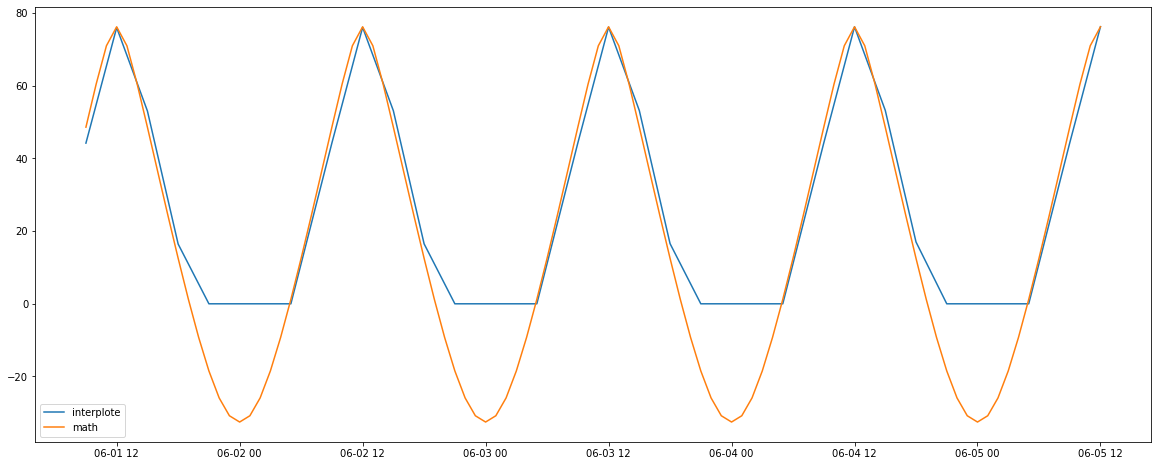

In [15]:
plt.figure(figsize=(20,8))
plt.plot(trial_['altitude01'][:100], label = 'interplote')
plt.plot(trial_['altitude02'][:100], label = 'math')
plt.legend()
plt.show()

<Figure size 1440x576 with 0 Axes>

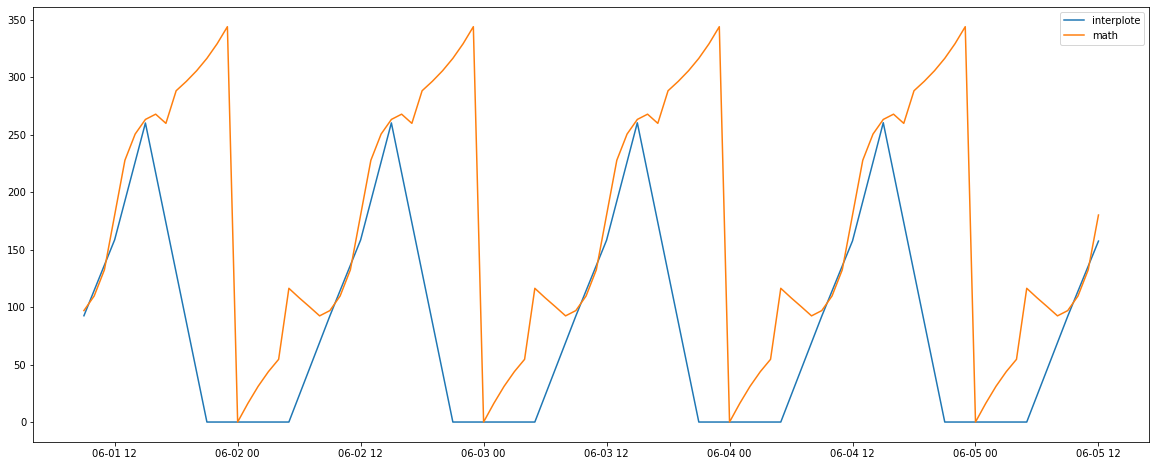

In [16]:
plt.figure(figsize=(20,8))
plt.plot(trial_['azimuth01'][:100], label = 'interplote')
plt.plot(trial_['azimuth02'][:100], label = 'math')
plt.legend()
plt.show()

In [17]:
dataset['altitude'] = trial_1['altitude']
dataset['azimuth'] = trial_1['azimuth']
dataset['altitude_m'] = total_alti['elevation']
dataset['azimuth_m'] = total_alti['azimuth']

## (2) OneHotEncoder

In [18]:
def night(x) :
  if x > 20 or x < 6 : return 1
  else : return 0
  
def season(x) : 
  if x in [12,1,2] : return 0 #winter 
  elif x in [6,7,8] : return 1 #summer
  elif x in [9,10,11] : return 2 #fall
  else : return 3 #sring

In [19]:
from sklearn.preprocessing import OneHotEncoder
sky = pd.DataFrame()
sky['sky'] = dataset['sky'].round().astype('int')
sky['night'] = dataset['hour'].apply(lambda x : night(x))
sky['season'] = dataset['month'].apply(lambda x : season(x))

enc= OneHotEncoder()
enc.fit(sky)

One = enc.transform(sky).toarray()

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [20]:
One_t = np.transpose(One)
x = 0
for i in enc.get_feature_names() :   
  
  dataset[i] = One_t[x]
  x += 1

dataset.head()

,solar_result,temp,rain_r,hum,wind,wins,sky,azimuth,altitude,hour,year,month,day,altitude_m,azimuth_m,x0_1,x0_2,x0_3,x0_4,x1_0,x1_1,x2_0,x2_1,x2_2,x2_3
datetime,,,,,,,,,,,,,,,,,,,,,,,,,
2017-06-01 09:00:00,33.12,21.000000,0.0,65.000000,2.400000,2.400000,1.0,92.420000,44.230000,9,2017,6,1,48.617684,96.897301,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 10:00:00,50.16,21.333333,0.0,65.000000,2.333333,2.333333,1.0,114.446667,54.833333,10,2017,6,1,60.487336,109.600378,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 11:00:00,96.72,21.666667,0.0,65.000000,2.266667,2.266667,1.0,136.473333,65.436667,11,2017,6,1,71.021213,132.383793,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 12:00:00,120.96,22.000000,0.0,65.000000,2.200000,2.200000,1.0,158.500000,76.040000,12,2017,6,1,76.252859,180.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 13:00:00,118.80,21.333333,0.0,63.333333,2.433333,2.433333,1.0,192.333333,68.386667,13,2017,6,1,71.021213,227.616207,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27016 entries, 2017-06-01 09:00:00 to 2020-07-01 00:00:00
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   solar_result  27016 non-null  float64
 1   temp          27016 non-null  float64
 2   rain_r        27016 non-null  float64
 3   hum           27016 non-null  float64
 4   wind          27016 non-null  float64
 5   wins          27016 non-null  float64
 6   sky           27016 non-null  float64
 7   azimuth       27016 non-null  float64
 8   altitude      27016 non-null  float64
 9   hour          27016 non-null  int64  
 10  year          27016 non-null  int64  
 11  month         27016 non-null  int64  
 12  day           27016 non-null  int64  
 13  altitude_m    27016 non-null  float64
 14  azimuth_m     27016 non-null  float64
 15  x0_1          27016 non-null  float64
 16  x0_2          27016 non-null  float64
 17  x0_3          27016 non-null  floa

## (3) Corr

<Figure size 1080x1080 with 0 Axes>

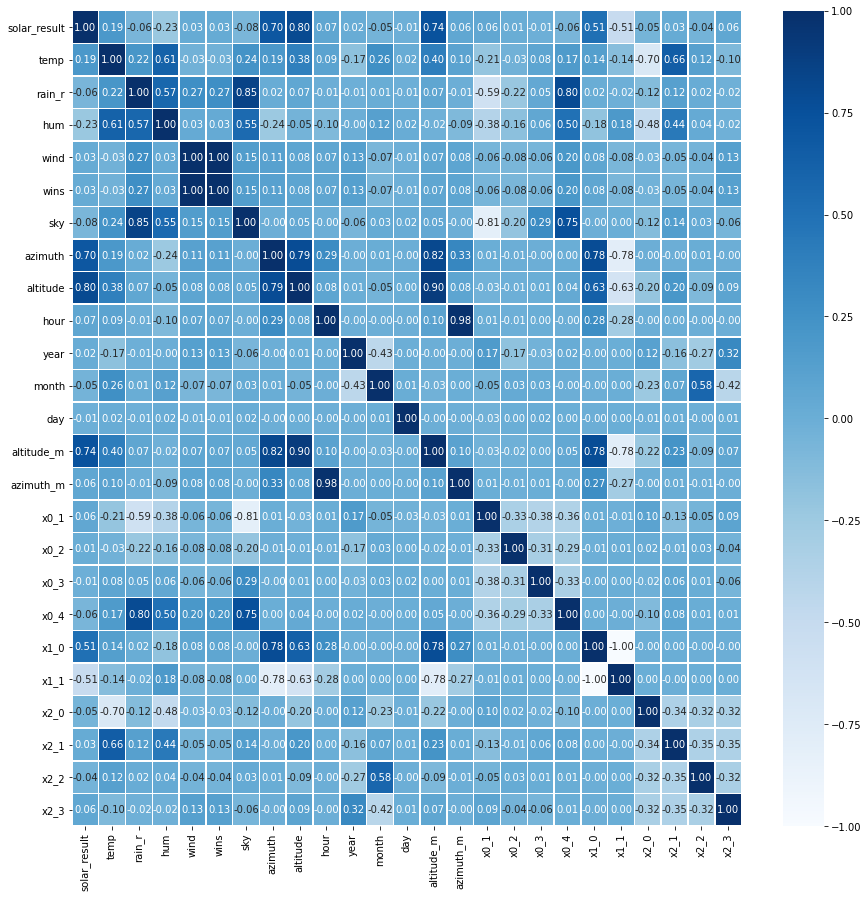

In [22]:
plt.figure(figsize=(15,15))
sns.heatmap(data=dataset.corr(method='pearson'), annot=True,fmt='.2f', linewidths=.5, cmap='Blues')

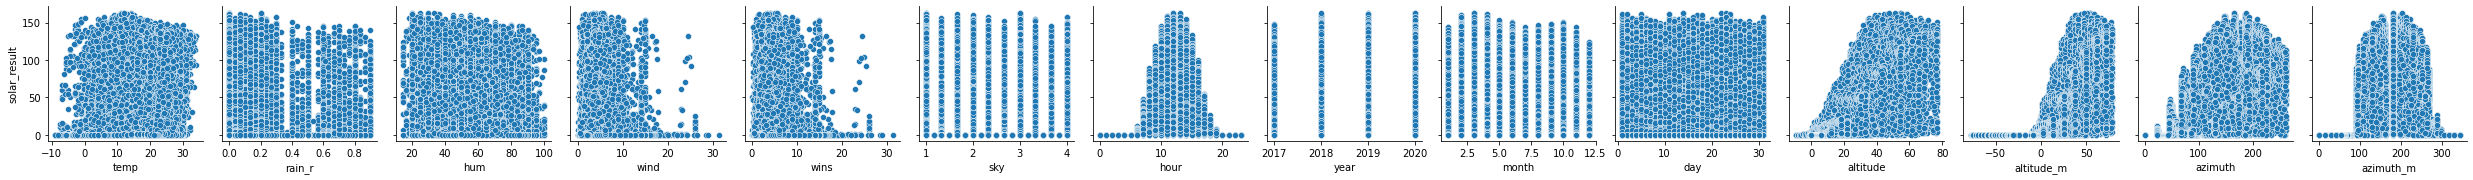

In [23]:
sns.pairplot(dataset, x_vars=['temp', 'rain_r', 'hum', 'wind', 'wins', 'sky', 'hour',
       'year', 'month', 'day', 'altitude','altitude_m','azimuth','azimuth_m'],y_vars=['solar_result'])

### VIF

In [32]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y = dataset['solar_result']
x = dataset.loc[:,'temp':]

In [36]:
lm = sm.OLS(y,x)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           solar_result   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     3326.
Date:                Mon, 19 Jul 2021   Prob (F-statistic):               0.00
Time:                        00:36:29   Log-Likelihood:            -1.2334e+05
No. Observations:               27016   AIC:                         2.467e+05
Df Residuals:                   26995   BIC:                         2.469e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.3683      0.040      9.192      0.000       0.290       0.447
rain_r         0.8414      1.632      0.516      0.606      -2.357       4.040
hum           -0.3899      0.015    -25.370      0.000      -0.420      -0.360
wind          -0.2655      0.031     -8.476      0.000      -0.327      -0.204
wins          -0.2655      0.031     -8.476      0.000      -0.327      -0.204
sky           -1.3675      1.129     -1.211      0.226      -3.581       0.846
azimuth        0.1253      0.005     26.396      0.000       0.116       0.135
altitude       1.1219      0.018     61.248      0.000       1.086       1.158
hour           2.9601      0.131     22.571      0.000       2.703       3.217
year           0.7274      0.172      4.239      0.000       0.391       1.064
month         -0.0245      0.058     -0.424      0.672      -0.138       0.089
day           -0.0277      0.016     -1.719      0.086      -0.059       0.004
altitude_m     0.2998      0.013     23.980      0.000       0.275       0.324
azimuth_m     -0.2181      0.009    -23.247      0.000      -0.237      -0.200
x0_1        -359.7833     86.609     -4.154      0.000    -529.542    -190.024
x0_2        -360.2512     86.546     -4.163      0.000    -529.886    -190.616
x0_3        -359.3135     86.617     -4.148      0.000    -529.087    -189.540
x0_4        -358.5466     86.652     -4.138      0.000    -528.389    -188.704
x1_0        -730.3265    173.193     -4.217      0.000   -1069.794    -390.859
x1_1        -707.5681    173.197     -4.085      0.000   -1047.043    -368.093
x2_0        -353.0775     86.632     -4.076      0.000    -522.881    -183.273
x2_1        -367.5138     86.543     -4.247      0.000    -537.142    -197.885
x2_2        -357.3549     86.578     -4.128      0.000    -527.053    -187.657
x2_3        -359.9484     86.639     -4.155      0.000    -529.765    -190.132
==============================================================================
Omnibus:                     2185.138   Durbin-Watson:                   0.314
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6862.255
Skew:                          -0.413   Prob(JB):                         0.00
Kurtosis:                       5.327   Cond. No.                     2.02e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.72e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [35]:
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['features'] = x.columns
vif

,VIF Factor,features
0,5.655265,temp
1,5.368381,rain_r
2,3.774181,hum
3,inf,wind
4,inf,wins
5,81.503198,sky
6,7.330739,azimuth
7,7.298545,altitude
8,41.135819,hour
9,1.398390,year


In [45]:
x_ver1 = x.drop(['azimuth_m','sky','month','rain_r'],1) #Multicollinearity : azimuth_m, sky / P> 0.05 : month, rain_r

lm = sm.OLS(y, x_ver1)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           solar_result   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     4043.
Date:                Mon, 19 Jul 2021   Prob (F-statistic):               0.00
Time:                        00:43:05   Log-Likelihood:            -1.2361e+05
No. Observations:               27016   AIC:                         2.473e+05
Df Residuals:                   26999   BIC:                         2.474e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.4056      0.040     10.105      0.000       0.327       0.484
hum           -0.4227      0.015    -28.666      0.000      -0.452      -0.394
wind          -0.2851      0.030     -9.351      0.000      -0.345      -0.225
wins          -0.2851      0.030     -9.351      0.000      -0.345      -0.225
azimuth        0.0694      0.004     16.847      0.000       0.061       0.078
altitude       1.2214      0.018     67.991      0.000       1.186       1.257
hour          -0.0390      0.024     -1.641      0.101      -0.086       0.008
year           0.7799      0.166      4.696      0.000       0.454       1.105
day           -0.0270      0.016     -1.663      0.096      -0.059       0.005
altitude_m     0.3153      0.013     25.024      0.000       0.291       0.340
x0_1        -385.2954     83.816     -4.597      0.000    -549.579    -221.012
x0_2        -387.0666     83.731     -4.623      0.000    -551.183    -222.950
x0_3        -387.2739     83.763     -4.623      0.000    -551.454    -223.094
x0_4        -387.0948     83.740     -4.623      0.000    -551.229    -222.960
x1_0        -783.2166    167.522     -4.675      0.000   -1111.568    -454.865
x1_1        -763.5142    167.526     -4.558      0.000   -1091.874    -435.154
x2_0        -379.3789     83.815     -4.526      0.000    -543.660    -215.097
x2_1        -395.9396     83.705     -4.730      0.000    -560.006    -231.873
x2_2        -383.9875     83.690     -4.588      0.000    -548.025    -219.950
x2_3        -387.4248     83.840     -4.621      0.000    -551.756    -223.094
==============================================================================
Omnibus:                     2067.821   Durbin-Watson:                   0.290
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7058.412
Skew:                          -0.358   Prob(JB):                         0.00
Kurtosis:                       5.400   Cond. No.                     3.34e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.89e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [46]:
vif_1 = pd.DataFrame()
vif_1['VIF Factor'] = [variance_inflation_factor(x_ver1.values, i) for i in range(x_ver1.shape[1])]
vif_1['features'] = x_ver1.columns
vif_1

,VIF Factor,features
0,5.564564,temp
1,3.406669,hum
2,inf,wind
3,inf,wins
4,5.418644,azimuth
5,6.882747,altitude
6,1.328120,hour
7,1.284015,year
8,1.001564,day
9,11.440650,altitude_m


## GridSearch

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

svr = SVR()

grid_param_svr = {
    'C': [10, 50, 100, 200, 300, 500, 600, 800, 900, 1000],
    'epsilon' : [0.1, 0.2, 0.3]
}

gs_svr = GridSearchCV(estimator=svr, 
                      param_grid=grid_param_svr, 
                      cv=8,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = 1)

%time gs_svr = gs_svr.fit(X_train_sc,y_train)

CPU times: user 2h 18min 14s, sys: 8.55 s, total: 2h 18min 22s
Wall time: 2h 17min 52s


In [28]:
gs_svr.best_params_

{'C': 800, 'epsilon': 0.1}

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

gbr = GradientBoostingRegressor()

grid_param_svr = {
    'n_estimators': [10, 50, 100, 200, 300, 500, 600, 800, 900, 1000],

}

gs_svr = GridSearchCV(estimator=gbr, 
                      param_grid=grid_param_svr, 
                      cv=8,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = 1)

%time gs_svr = gs_svr.fit(X_train,y_train)

CPU times: user 8min 49s, sys: 447 ms, total: 8min 49s
Wall time: 8min 47s


In [30]:
gs_svr.best_params_

{'n_estimators': 200}

# Trial03. feature selection(use)

- using GridSearch Par = C : 800, n-estimator = 200
- drop : Multicollinearity : azimuth_m, sky / P> 0.05 : month, rain_r


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

In [49]:
dataset_ver1 = dataset.drop(['azimuth_m', 'sky', 'month','rain_r'],1)
dataset_ver1.head()

,solar_result,temp,hum,wind,wins,azimuth,altitude,hour,year,day,altitude_m,x0_1,x0_2,x0_3,x0_4,x1_0,x1_1,x2_0,x2_1,x2_2,x2_3
datetime,,,,,,,,,,,,,,,,,,,,,
2017-06-01 09:00:00,33.12,21.000000,65.000000,2.400000,2.400000,92.420000,44.230000,9,2017,1,48.617684,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 10:00:00,50.16,21.333333,65.000000,2.333333,2.333333,114.446667,54.833333,10,2017,1,60.487336,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 11:00:00,96.72,21.666667,65.000000,2.266667,2.266667,136.473333,65.436667,11,2017,1,71.021213,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 12:00:00,120.96,22.000000,65.000000,2.200000,2.200000,158.500000,76.040000,12,2017,1,76.252859,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 13:00:00,118.80,21.333333,63.333333,2.433333,2.433333,192.333333,68.386667,13,2017,1,71.021213,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset_ver1.loc[:,'temp':], dataset_ver1.loc[:,'solar_result'], test_size = 0.75, random_state = 42)

In [52]:
df = svr_gbr('seletion', X_train, y_train, X_test, y_test, 800, 200)
df.head()

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=800, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
SVM 훈련 세트 점수: 0.84494839257161 
SVM 테스트 세트 점수 : 0.7806816001039693
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          rando

,result,seletionSVM,seletiongbr
datetime,,,
2017-10-31 23:00:00,0.00,-0.174991,0.386361
2018-02-10 21:00:00,0.00,-0.125434,-0.029523
2018-08-17 01:00:00,0.00,-0.113268,-0.180837
2018-12-08 03:00:00,0.00,-0.050619,-1.298196
2019-01-10 14:00:00,102.72,92.525903,85.322324


In [53]:
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

svr = SVR(C=800, epsilon=0.1)
svr.fit(X_train_sc, y_train)
print(svr)
print(f"SVM 훈련 세트 점수: {svr.score(X_train_sc, y_train)} \nSVM 테스트 세트 점수 : {svr.score(X_test_sc, y_test)}")

SVR(C=800, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR(C=800, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
SVM 훈련 세트 점수: 0.8446778548200643 
SVM 테스트 세트 점수 : 0.7805824312352545


<BarContainer object of 20 artists>

Text(0.5, 0, 'Permutation Importance')

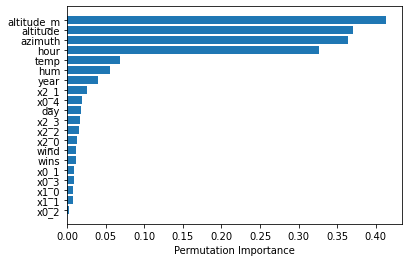

In [54]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(svr, X_test_sc, y_test)

feature_names = X_train.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")